In [13]:
import requests
import zipfile
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
from datetime import date, datetime, timedelta
import pandas as pd
from ggplot import *
import sqlite3

In [ ]:
## PV watts main site: http://pvwatts.nrel.gov/pvwatts.php
## API description: https://developer.nrel.gov/docs/solar/pvwatts-v5/

In [40]:
q_base = 'https://developer.nrel.gov/api/pvwatts/v5.xml?'

In [41]:
# Station in Santa Monica, LA
q_main = 'lat=34.02&lon=-118.45&system_capacity=4&azimuth=180&tilt=40&array_type=1&module_type=1&losses=10&timeframe=hourly&'

In [42]:
# Get API key at: http://pvwatts.nrel.gov/pvwatts.php
api_key = 'api_key='

In [ ]:
print q_base + q_main + api_key

In [44]:
r = requests.get(q_base + q_main + api_key)
open('extract','wb').write(r.content)

In [46]:
tree = ET.fromstring(r.content)

In [48]:
soup = BeautifulSoup(r.content,"lxml")
print soup.prettify()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [75]:
# Extract ac output for each hour in the year
gen = []
for data in tree.iter('ac'):
    gen.append(data.text)

In [83]:
### Gen includes parent as first entry (which is empty here; remove; length should be 0)
del(gen[0])
len(gen)

8760

In [ ]:
### Convert entries into dataframe with dates; use starting hours (0-23)

In [88]:
start = datetime.strptime('01/01/2017 00','%m/%d/%Y %H')
end = datetime.strptime('12/31/2017 23','%m/%d/%Y %H')

In [90]:
# Verify that this homeslice worked
print start , ' to ' , end

2017-01-01 00:00:00  to  2017-12-31 23:00:00


In [107]:
### Generate datetime variables for each out between the start and end dates

delta = end - start

hour_steps = []

for i in range((delta.days + 1)*24):
    hour_steps.append(start + timedelta(hours = i))

In [108]:
len(hour_steps)

8760

In [114]:
la_gen = pd.DataFrame(
    {'date_time':hour_steps,
    'generation': gen})

In [127]:
### Create hour of the day variable
la_gen['hour'] = la_gen['date_time'].apply(lambda x: datetime.strftime(x,'%H'))

,date_time,generation,hour
8736,2017-12-31 00:00:00,0.0,00
8737,2017-12-31 01:00:00,0.0,01
8738,2017-12-31 02:00:00,0.0,02
8739,2017-12-31 03:00:00,0.0,03
8740,2017-12-31 04:00:00,0.0,04
8741,2017-12-31 05:00:00,0.0,05
8742,2017-12-31 06:00:00,0.0,06
8743,2017-12-31 07:00:00,182.058,07
8744,2017-12-31 08:00:00,436.885,08
8745,2017-12-31 09:00:00,481.294,09


In [134]:
print la_gen['date_time']

2017-01-01 00:00:00


In [143]:
la_gen['date_time'][0] == datetime.strptime('2017-01-01','%Y-%m-%d')

True

In [147]:
print la_gen[(la_gen['date_time'] >= datetime.strptime('2017-01-01','%Y-%m-%d')) & (la_gen['date_time'] < datetime.strptime('2017-01-02','%Y-%m-%d'))]

             date_time generation hour
0  2017-01-01 00:00:00        0.0   00
1  2017-01-01 01:00:00        0.0   01
2  2017-01-01 02:00:00        0.0   02
3  2017-01-01 03:00:00        0.0   03
4  2017-01-01 04:00:00        0.0   04
5  2017-01-01 05:00:00        0.0   05
6  2017-01-01 06:00:00        0.0   06
7  2017-01-01 07:00:00     91.636   07
8  2017-01-01 08:00:00    911.124   08
9  2017-01-01 09:00:00   1345.334   09
10 2017-01-01 10:00:00   2007.005   10
11 2017-01-01 11:00:00   2327.701   11
12 2017-01-01 12:00:00   2625.026   12
13 2017-01-01 13:00:00    2300.32   13
14 2017-01-01 14:00:00     1636.5   14
15 2017-01-01 15:00:00    822.792   15
16 2017-01-01 16:00:00    117.353   16
17 2017-01-01 17:00:00        0.0   17
18 2017-01-01 18:00:00        0.0   18
19 2017-01-01 19:00:00        0.0   19
20 2017-01-01 20:00:00        0.0   20
21 2017-01-01 21:00:00        0.0   21
22 2017-01-01 22:00:00        0.0   22
23 2017-01-01 23:00:00        0.0   23


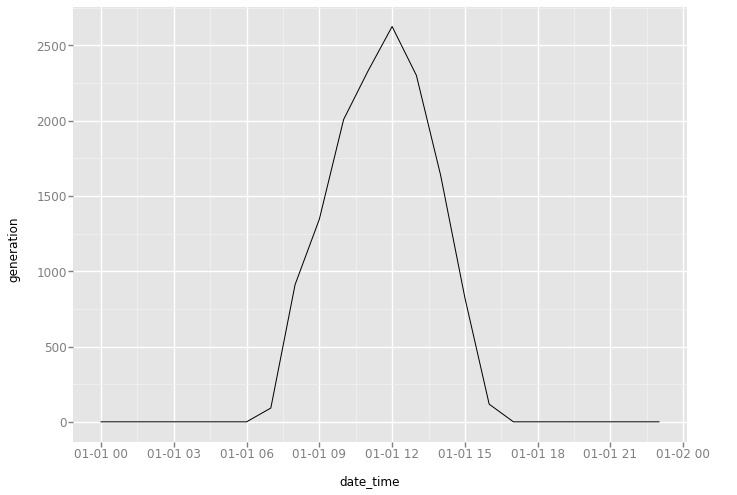

<ggplot: (35199064)>

In [160]:
ggplot(aes(x = 'date_time', y= 'generation'), data = la_gen[(la_gen['date_time'] >= datetime.strptime('2017-01-01','%Y-%m-%d')) & (la_gen['date_time'] < datetime.strptime('2017-01-02','%Y-%m-%d'))]) + \
geom_line()

In [158]:
la_gen['generation'] = la_gen['generation'].astype('float')

In [ ]:
### Create database so you don't have to do it again

In [163]:
conn = sqlite3.connect('pv_production_CA.db')

In [164]:
cur = conn.cursor()

In [167]:
la_gen.to_sql('la_gen',conn)

In [174]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[(u'la_gen',)]


In [ ]:
conn.close()